<a href="https://colab.research.google.com/github/jongbokhi/master_thesis_2023/blob/main/Adversarial_training_A2PM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install a2pm

In [35]:
import numpy as np
import pandas as pd
import joblib
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, accuracy_score, recall_score

from a2pm import A2PMethod
from a2pm.callbacks import BaseCallback, MetricCallback, TimeCallback
from a2pm.patterns import BasePattern, CombinationPattern, IntervalPattern
from a2pm.wrappers import BaseWrapper, KerasWrapper, SklearnWrapper, TorchWrapper


from imblearn.pipeline import make_pipeline
from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN

from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split, StratifiedKFold
from sklearn.metrics import precision_recall_curve, auc, roc_curve, accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, confusion_matrix, classification_report, ConfusionMatrixDisplay

import warnings

# Ignore the warning about missing feature names
warnings.filterwarnings("ignore", category=UserWarning)

In [21]:
origin_X_train = pd.read_csv('/content/drive/MyDrive/new_cic_ids_2018 data/X_train.csv')
origin_y_train = pd.read_csv('/content/drive/MyDrive/new_cic_ids_2018 data/y_train.csv')

In [22]:
origin_train_df = pd.concat([origin_X_train, origin_y_train], axis=1, ignore_index=False)

In [23]:
fake_df = pd.read_csv('/content/drive/MyDrive/new_cic_ids_2018 data/fake_benign_df.csv')

In [24]:
combined_train_df = pd.concat([origin_train_df, fake_df], axis=0, ignore_index=False)

In [25]:
##Sort the feature and Target variable
com_x_train = combined_train_df.drop('Label', axis=1).copy()
com_y_train = combined_train_df['Label'].copy()

In [26]:
pattern = (

    # First pattern to be applied: Interval
    {
        "type": "interval",
        "features": list(range(0, 20)),
        "integer_features": list(range(10, 20)),
        "ratio": 0.1,
        "max_ratio": 0.3,
        "missing_value": 0.0,
        "probability": 0.6,
    },

    # Second pattern to be applied: Combination
    {
        "type": "combination",
        "features": list(range(17, 40)),
        "locked_features": list(range(30, 40)),
        "probability": 0.4,
    },
)

method = A2PMethod(pattern)

In [27]:
# Create an instance of the IntervalPattern
pattern = IntervalPattern()

# Set the target label for malicious samples as 'Benign' (0)
pattern.partial_fit(com_x_train[com_y_train == 1])

# Create an instance of the A2PM classifier
a2pm_classifier = A2PMethod(pattern)

In [28]:
# Adapts to new data, and then creates adversarial examples
X_adversarial = a2pm_classifier.fit_transform(com_x_train, com_y_train)

In [29]:
X_adversarial.shape

(112625, 17)

In [30]:
adversarial_X_df = pd.DataFrame(X_adversarial, columns=com_x_train.columns.tolist())

In [31]:
adversarial_X_df

,Bwd IAT Tot,Bwd Pkt Len Max,Flow Duration,Flow IAT Min,Fwd Header Len,Fwd IAT Mean,Fwd IAT Min,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Std,Fwd Pkts/s,Fwd Seg Size Min,Init Bwd Win Byts,Init Fwd Win Byts,Tot Bwd Pkts,TotLen Bwd Pkts,TotLen Fwd Pkts
0,1.436462e-01,0.517021,4.521146e-02,4.167905e-08,1.736668e-03,0.015067,9.853812e-02,0.012310,2.689266e-02,0.047232,1.843191e-07,0.727273,4.459839e-02,0.044469,5.832037e-04,8.655701e-05,0.000000e+00
1,9.844186e-01,0.323347,8.677184e-01,8.252451e-09,1.628331e-03,0.162881,1.575468e-06,0.016935,2.762373e-02,0.024386,3.450151e-08,0.500545,2.639771e-03,0.166625,1.814412e-03,1.071439e-03,5.186813e-05
2,9.842612e-02,0.051702,4.122668e-04,5.787699e-02,8.944210e-04,0.000206,0.000000e+00,0.000000,2.689266e-02,0.000000,1.516009e-05,0.727273,4.096680e-02,0.003448,0.000000e+00,8.655701e-06,7.471341e-05
3,0.000000e+00,0.147815,3.541439e-02,5.835067e-08,1.565237e-03,0.107308,2.000594e-07,0.046638,0.000000e+00,0.094140,2.941366e-07,0.727273,3.234863e-03,0.003357,3.888025e-04,3.348296e-05,1.182948e-03
4,0.000000e+00,0.750000,8.250002e-09,8.335810e-09,3.253717e-03,0.000000,9.845228e-02,0.010076,0.000000e+00,0.031582,7.193757e-07,0.454545,1.770020e-03,0.083405,0.000000e+00,3.196020e-04,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112620,1.363973e-07,0.729689,7.975982e-05,5.824882e-02,2.405331e-07,0.000039,1.658720e-08,0.015793,1.257573e-07,0.008791,2.575000e-02,0.444282,4.069308e-11,0.106876,4.427034e-19,5.112379e-07,1.562691e-18
112621,3.744506e-05,0.056838,8.250002e-09,1.014142e-05,2.951589e-04,0.098721,6.259250e-05,0.001097,2.770922e-02,0.000000,4.191764e-09,0.533212,0.000000e+00,0.000015,0.000000e+00,1.009648e-03,0.000000e+00
112622,1.078365e-03,0.014979,8.437640e-03,8.252451e-09,9.730097e-04,0.001019,9.396006e-05,0.010272,8.428859e-05,0.000000,5.286213e-02,0.558005,4.226054e-02,0.000382,2.627422e-03,0.000000e+00,2.852878e-03
112623,9.846924e-02,0.057586,1.467600e-03,8.545368e-06,2.951589e-04,0.000000,0.000000e+00,0.000940,2.770312e-02,0.000455,6.823822e-03,0.485302,5.665007e-02,0.000015,9.683298e-06,0.000000e+00,1.076400e-03


In [32]:
#1. Split dataset into Training, Validation and Testing set
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(adversarial_X_df, com_y_train, test_size=0.33, random_state=12, stratify=com_y_train)

In [33]:
#Save training and testing dataset

X_train.to_csv("/content/drive/MyDrive/adversarial datasets_a2pm/adversary_X_train.csv", index=False)

y_train.to_csv("/content/drive/MyDrive/adversarial datasets_a2pm/adversary_y_train.csv", index=False)

X_test.to_csv("/content/drive/MyDrive/adversarial datasets_a2pm/adversary_X_test.csv", index=False)

y_test.to_csv("/content/drive/MyDrive/adversarial datasets_a2pm/adversary_y_test.csv", index=False)

## Optimize Hyperparameter of each models

Models

>Random Forest, Decision Tree, Naive Baye, SVM, XGBoost, LightGBM, Logistic Regression

In [36]:
kf = StratifiedKFold(n_splits=5, random_state=13, shuffle=True)

##Random Forest


In [37]:
##Baseline
#the default hyperparameters
rf = RandomForestClassifier(n_estimators=10, random_state=13, n_jobs=-1)

# Fit model
rf.fit(X_train, y_train)

#predict
rf_pred = rf.predict(X_test)

# print prediction results
print(classification_report(y_test, rf_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     32798
           1       1.00      1.00      1.00      4369

    accuracy                           1.00     37167
   macro avg       1.00      1.00      1.00     37167
weighted avg       1.00      1.00      1.00     37167



In [38]:
rf_pipeline = make_pipeline(SMOTE(sampling_strategy= 1 , random_state=12, n_jobs= -1), RandomForestClassifier(n_estimators=100, random_state=13, n_jobs=-1))

rf_pipeline

Pipeline(steps=[('smote',
                 SMOTE(n_jobs=-1, random_state=12, sampling_strategy=1)),
                ('randomforestclassifier',
                 RandomForestClassifier(n_jobs=-1, random_state=13))])

In [39]:
# evaluate pipeline

cross_val_score(rf_pipeline, X_train, y_train, scoring='recall', cv=kf, n_jobs=-1)

array([0.9994363 , 0.9988726 , 1.        , 0.99943598, 1.        ])

In [40]:
#GridSearch

%%time

rf_params = {
             'criterion': ['gini', 'entropy'],
             'n_estimators': [50, 100,200],
             'min_samples_leaf': [3, 0.0001, 0.0005, 0.00001],
             'min_samples_split': [8, 0.0005, 0.0001, 0.00001],
             'max_depth': [50, 100, 200],
             'random_state': [13]
             }


rf_new_params = {'randomforestclassifier__' + key: rf_params[key] for key in rf_params}

rf_grid = GridSearchCV(rf_pipeline, param_grid=rf_new_params, cv=kf, scoring='recall', n_jobs=-1,
                        return_train_score=True, verbose=0)
#Fit
rf_grid.fit(X_train, y_train)

##the result of GridSearch

  #Best Score: F1
rf_best = rf_grid.best_score_
  #Optimized hyperparameters
rf_opt_params = rf_grid.best_params_

print("=================GridSearch Result=================")
print()
print(f"GridSearch Best Score_recall: \n{rf_best}")
print(f"Best Hyperparameters: \n{rf_opt_params}")
print()
print("===================================================")

/usr/local/lib/python3.10/dist-packages/imblearn/over_sampling/_smote/base.py:336: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


=================GridSearch Result=================

GridSearch Best Score_recall: 
0.9995489781267427
Best Hyperparameters: 
{'randomforestclassifier__criterion': 'gini', 'randomforestclassifier__max_depth': 50, 'randomforestclassifier__min_samples_leaf': 3, 'randomforestclassifier__min_samples_split': 8, 'randomforestclassifier__n_estimators': 50, 'randomforestclassifier__random_state': 13}

CPU times: user 46.4 s, sys: 3.69 s, total: 50.1 s
Wall time: 1h 9min 17s


In [41]:
##evaluate Model

# Prediction using Estimator that was chosen by the GridSearch for testidation dataset
model_rf = rf_grid.best_estimator_

rf_test_pre = model_rf.predict(X_test)

rf_accuracy = accuracy_score(y_test, rf_test_pre)
rf_pre_f1 = f1_score(y_test, rf_test_pre)
rf_recall = recall_score(y_test, rf_test_pre)
rf_precison = precision_score(y_test, rf_test_pre)

print(classification_report(y_test, rf_test_pre))
print()
print("==================Evaluation Score==================")
print(f"test_Accuracy: \n{rf_accuracy}")
print(f"test_F1: \n{rf_pre_f1}")
print(f"test_Recall: \n{rf_recall}")
print(f"test_Precision: \n{rf_precison}")
print("===================================================")

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     32798
           1       1.00      1.00      1.00      4369

    accuracy                           1.00     37167
   macro avg       1.00      1.00      1.00     37167
weighted avg       1.00      1.00      1.00     37167


==================Evaluation Score==================
test_Accuracy: 
0.9999461888234186
test_F1: 
0.9997711146715496
test_Recall: 
0.9997711146715496
test_Precision: 
0.9997711146715496


In [42]:
#Saving model
joblib.dump(model_rf, "/content/drive/MyDrive/adversarial trained models/ad_RandomForest.pkl")

['/content/drive/MyDrive/adversarial trained models/ad_RandomForest.pkl']

##Naive Bayes

In [43]:
##Baseline
#the default hyperparameters
nb = GaussianNB()

# Fit model
nb.fit(X_train, y_train)

#predict
nb_pred = nb.predict(X_test)

# print prediction results
print(classification_report(y_test, nb_pred))

              precision    recall  f1-score   support

           0       1.00      0.95      0.97     32798
           1       0.73      0.97      0.83      4369

    accuracy                           0.95     37167
   macro avg       0.86      0.96      0.90     37167
weighted avg       0.96      0.95      0.96     37167



In [44]:
nb_pipeline = make_pipeline(SMOTE(sampling_strategy= 1 , random_state=12, n_jobs= -1), GaussianNB())

nb_pipeline

Pipeline(steps=[('smote',
                 SMOTE(n_jobs=-1, random_state=12, sampling_strategy=1)),
                ('gaussiannb', GaussianNB())])

In [45]:
cross_val_score(nb_pipeline, X_train, y_train, scoring='accuracy', cv=kf, n_jobs=-1)

array([0.92751126, 0.93188444, 0.93817917, 0.92810284, 0.92975946])

In [46]:
#GridSearch
%%time

nb_params = [{'var_smoothing': np.logspace(0, -9, num=100)}]


nb_new_params = {'gaussiannb__' + key: value for param in nb_params for key, value in param.items()}

#nb_new_params = {'naivebayesclassifier__' + key: nb_params[key] for key in nb_params}

nb_grid = GridSearchCV(nb_pipeline, param_grid=nb_new_params, cv=kf, scoring='accuracy', n_jobs=-1,
                        return_train_score=True, verbose=0)

#Fit
nb_grid.fit(X_train, y_train)

##the result of GridSearch

  #Best Score: Accuracy
nb_best = nb_grid.best_score_
  #Optimized hyperparameters
nb_opt_params = nb_grid.best_params_

print("=================GridSearch Result=================")
print()
print(f"GridSearch Best Score_Recall: \n{nb_best}")
print(f"Best Hyperparameters: \n{nb_opt_params}")
print()
print("===================================================")

/usr/local/lib/python3.10/dist-packages/imblearn/over_sampling/_smote/base.py:336: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


=================GridSearch Result=================

GridSearch Best Score_Recall: 
0.9869993933613419
Best Hyperparameters: 
{'gaussiannb__var_smoothing': 0.0008111308307896872}

CPU times: user 4.6 s, sys: 1.27 s, total: 5.87 s
Wall time: 27.9 s


In [47]:
##Evaluate Model

# Prediction using Estimator that was chosen by the GridSearch for test dataset
model_nb = nb_grid.best_estimator_
nb_test_pre = model_nb.predict(X_test)


nb_pre_accuracy = accuracy_score(y_test, nb_test_pre)
nb_pre_f1 = f1_score(y_test, nb_test_pre)
nb_recall = recall_score(y_test, nb_test_pre)
nb_precision = precision_score(y_test, nb_test_pre)

print(classification_report(y_test, nb_test_pre))
print()
print("==================Evaluation Score==================")
print(f"test_Accuaracy: \n{nb_pre_accuracy}")
print(f"test_F1: \n{nb_pre_f1}")
print(f"test_Recall: \n{nb_recall}")
print(f"test_Precison: \n{nb_precision}")
print("===================================================")

              precision    recall  f1-score   support

           0       1.00      0.99      0.99     32798
           1       0.92      0.97      0.94      4369

    accuracy                           0.99     37167
   macro avg       0.96      0.98      0.97     37167
weighted avg       0.99      0.99      0.99     37167


==================Evaluation Score==================
test_Accuaracy: 
0.9858476605590981
test_F1: 
0.9413339281730982
test_Recall: 
0.9658960860608835
test_Precison: 
0.9179899934740048


In [48]:
#Saving model
joblib.dump(model_rf, "/content/drive/MyDrive/adversarial trained models/ad_NaiveBayes.pkl")

['/content/drive/MyDrive/adversarial trained models/ad_NaiveBayes.pkl']

##Support Vector Machine

In [49]:
##Baseline
#the default hyperparameters
svc = SVC()
# Fit model
svc.fit(X_train, y_train)

#predict
svc_pred = svc.predict(X_test)

# print prediction results
print(classification_report(y_test, svc_pred))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00     32798
           1       0.95      0.99      0.97      4369

    accuracy                           0.99     37167
   macro avg       0.97      0.99      0.98     37167
weighted avg       0.99      0.99      0.99     37167



In [50]:
svc_pipeline = make_pipeline(SMOTE(sampling_strategy= 1 , random_state=12, n_jobs= -1), SVC())

svc_pipeline

Pipeline(steps=[('smote',
                 SMOTE(n_jobs=-1, random_state=12, sampling_strategy=1)),
                ('svc', SVC())])

In [51]:
cross_val_score(svc_pipeline, X_train, y_train, scoring='recall', cv=kf, n_jobs=-1)

array([0.9994363 , 0.99661781, 0.9994363 , 0.99830795, 0.9988726 ])

In [52]:
#GridSearch
%%time

svc_params =  {'C': [1, 10],
                'gamma': [1, 0.1],
                'kernel': ['rbf', 'linear']
                }


svc_new_params = {'svc__' + key: svc_params[key] for key in svc_params}

svc_grid = GridSearchCV(svc_pipeline, param_grid=svc_new_params, cv=kf, scoring='recall', n_jobs=-1,
                        return_train_score=True, verbose=0)

#Fit
svc_grid.fit(X_train, y_train)

##the result of GridSearch

  #Best Score: Recall
svc_best = svc_grid.best_score_
  #Optimized hyperparameters
svc_opt_params = svc_grid.best_params_

print("=================GridSearch Result=================")
print()
print(f"GridSearch Best Score_Recall: \n{svc_best}")
print(f"Best Hyperparameters: \n{svc_opt_params}")
print()
print("===================================================")

/usr/local/lib/python3.10/dist-packages/imblearn/over_sampling/_smote/base.py:336: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


=================GridSearch Result=================

GridSearch Best Score_Recall: 
0.9990980198403842
Best Hyperparameters: 
{'svc__C': 10, 'svc__gamma': 1, 'svc__kernel': 'rbf'}

CPU times: user 28.4 s, sys: 1.19 s, total: 29.6 s
Wall time: 8min 17s


In [53]:
##Evaluate Model

# Prediction using Estimator that was chosen by the GridSearch for test dataset
model_svc = svc_grid.best_estimator_
svc_test_pre = model_svc.predict(X_test)

svc_pre_accuracy = accuracy_score(y_test, svc_test_pre)
svc_pre_f1 = f1_score(y_test, svc_test_pre)
svc_recall= recall_score(y_test, svc_test_pre)
svc_precision = precision_score(y_test, svc_test_pre)

print(classification_report(y_test, svc_test_pre))
print()
print("==================Evaluation Score==================")
print(f"test_Accuracy: \n{svc_pre_accuracy}")
print(f"test_F1: \n{svc_pre_f1}")
print(f"test_Recall: \n{svc_recall}")
print(f"test_Precision: \n{svc_precision}")
print("===================================================")

              precision    recall  f1-score   support

           0       1.00      0.99      1.00     32798
           1       0.96      1.00      0.98      4369

    accuracy                           0.99     37167
   macro avg       0.98      1.00      0.99     37167
weighted avg       0.99      0.99      0.99     37167


==================Evaluation Score==================
test_Accuracy: 
0.9945919767535717
test_F1: 
0.9774840371905456
test_Recall: 
0.9986266880292973
test_Precision: 
0.9572180781044317


In [54]:
#Saving model
joblib.dump(model_svc, "/content/drive/MyDrive/adversarial trained models/ad_SVM.pkl")

['/content/drive/MyDrive/adversarial trained models/ad_SVM.pkl']

##XGBoost

In [55]:
##Baseline
from xgboost import XGBClassifier
#the default hyperparameters
xgb = XGBClassifier(objective= 'binary:logistic', seed=42)
# Fit model
xgb.fit(X_train, y_train)

#predict
xgb_pred = xgb.predict(X_test)

# print prediction results
print(classification_report(y_test, xgb_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     32798
           1       1.00      1.00      1.00      4369

    accuracy                           1.00     37167
   macro avg       1.00      1.00      1.00     37167
weighted avg       1.00      1.00      1.00     37167



In [56]:
xgb_pipeline = make_pipeline(SMOTE(sampling_strategy= 1 , random_state=12, n_jobs= -1), XGBClassifier(objective= 'binary:logistic', seed=42))

xgb_pipeline

Pipeline(steps=[('smote',
                 SMOTE(n_jobs=-1, random_state=12, sampling_strategy=1)),
                ('xgbclassifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=None, ...))])

In [57]:
cross_val_score(xgb_pipeline, X_train, y_train, scoring='recall', cv=kf, n_jobs=-1)

array([1.        , 0.9988726 , 1.        , 0.99943598, 1.        ])

In [60]:
#GridSearch
%%time

xgb_params = {
        'n_estimators':[50, 100, 200],
        'learning_rate': [0.1, 0.01],
        'min_child_weight': [1, 5, 10],
        'gamma': [0.1, 0.5],
        'subsample': [0.5, 1.0],
        'colsample_bytree': [0.5, 1.0],
        'max_depth': [5,10]
        }

xgb_new_params = {'xgbclassifier__' + key: xgb_params[key] for key in xgb_params}

xgb_grid = GridSearchCV(xgb_pipeline, param_grid= xgb_new_params, cv=kf, scoring='recall', n_jobs=-1,
                        return_train_score=True, verbose=0)

#Fit
xgb_grid.fit(X_train, y_train)

##the result of GridSearch

  #Best Score: Recall
xgb_best = xgb_grid.best_score_
  #Optimized hyperparameters
xgb_opt_params = xgb_grid.best_params_

print("=================GridSearch Result=================")
print()
print(f"GridSearch Best Score_Recall: \n{xgb_best}")
print(f"Best Hyperparameters: \n{xgb_opt_params}")
print()
print("===================================================")

/usr/local/lib/python3.10/dist-packages/imblearn/over_sampling/_smote/base.py:336: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


=================GridSearch Result=================

GridSearch Best Score_Recall: 
1.0
Best Hyperparameters: 
{'xgbclassifier__colsample_bytree': 0.5, 'xgbclassifier__gamma': 0.1, 'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__max_depth': 5, 'xgbclassifier__min_child_weight': 5, 'xgbclassifier__n_estimators': 200, 'xgbclassifier__subsample': 0.5}

CPU times: user 1min 37s, sys: 3.99 s, total: 1min 41s
Wall time: 1h 1min 8s


In [61]:
##Evaluate Model

# Prediction using Estimator that was chosen by the GridSearch for testing dataset
model_xgb = xgb_grid.best_estimator_
xgb_test_pre = model_xgb.predict(X_test)

xgb_pre_accuracy = accuracy_score(y_test, xgb_test_pre)
xgb_pre_f1 = f1_score(y_test, xgb_test_pre)
xgb_recall= recall_score(y_test, xgb_test_pre)
xgb_precision = precision_score(y_test, xgb_test_pre)

print(classification_report(y_test, xgb_test_pre))
print()
print("==================Evaluation Score==================")
print(f"test_F1: \n{xgb_pre_accuracy}")
print(f"test_F1: \n{xgb_pre_f1}")
print(f"test_Recall: \n{xgb_recall}")
print(f"test_Precision: \n{xgb_precision}")
print("===================================================")

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     32798
           1       1.00      1.00      1.00      4369

    accuracy                           1.00     37167
   macro avg       1.00      1.00      1.00     37167
weighted avg       1.00      1.00      1.00     37167


==================Evaluation Score==================
test_F1: 
0.9999730944117093
test_F1: 
0.9998855704313995
test_Recall: 
1.0
test_Precision: 
0.9997711670480549


In [62]:
#Saving model
joblib.dump(model_xgb, "/content/drive/MyDrive/adversarial trained models/ad_XGBoost.pkl")

['/content/drive/MyDrive/adversarial trained models/ad_XGBoost.pkl']

##LightGBM

In [63]:
##Baseline
import lightgbm as lgb
#the default hyperparameters
lgbm = lgb.LGBMClassifier()
# Fit model
lgbm.fit(X_train, y_train)

#predict
lgbm_pred = lgbm.predict(X_test)

# print prediction results
print(classification_report(y_test, lgbm_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     32798
           1       1.00      1.00      1.00      4369

    accuracy                           1.00     37167
   macro avg       1.00      1.00      1.00     37167
weighted avg       1.00      1.00      1.00     37167



In [64]:
lgbm_pipeline = make_pipeline(SMOTE(sampling_strategy= 1 , random_state=12, n_jobs= -1), lgb.LGBMClassifier())

lgbm_pipeline

Pipeline(steps=[('smote',
                 SMOTE(n_jobs=-1, random_state=12, sampling_strategy=1)),
                ('lgbmclassifier', LGBMClassifier())])

In [65]:
cross_val_score(lgbm_pipeline, X_train, y_train, scoring='recall', cv=kf, n_jobs=-1)

array([0.9994363 , 0.9994363 , 1.        , 0.99943598, 0.9988726 ])

In [66]:
#GridSearch
%%time

lgbm_params = {
    'n_estimators':[100, 200, 300],
    'num_leaves':[20,60,100],
    'max_depth':[5,10,15],
    'min_child_samples':[5,10,15],
    'learning_rate':[0.01, 0.05, 0.1],
    'reg_alpha':[0,0.01,0.03]
    }


lgbm_new_params = {'lgbmclassifier__' + key: lgbm_params[key] for key in lgbm_params}

lgbm_grid = GridSearchCV(lgbm_pipeline, param_grid= lgbm_new_params, cv=kf, scoring='recall', n_jobs=-1,
                        return_train_score=True, verbose=0)

#Fit
lgbm_grid.fit(X_train, y_train)

##the result of GridSearch

  #Best Score: Recall
lgbm_best = lgbm_grid.best_score_
  #Optimized hyperparameters
lgbm_opt_params = lgbm_grid.best_params_

print("=================GridSearch Result=================")
print()
print(f"GridSearch Best Score_Recall: \n{lgbm_best}")
print(f"Best Hyperparameters: \n{lgbm_opt_params}")
print()
print("===================================================")

/usr/local/lib/python3.10/dist-packages/imblearn/over_sampling/_smote/base.py:336: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


=================GridSearch Result=================

GridSearch Best Score_Recall: 
0.9997744572699219
Best Hyperparameters: 
{'lgbmclassifier__learning_rate': 0.01, 'lgbmclassifier__max_depth': 5, 'lgbmclassifier__min_child_samples': 15, 'lgbmclassifier__n_estimators': 200, 'lgbmclassifier__num_leaves': 20, 'lgbmclassifier__reg_alpha': 0.01}

CPU times: user 1min 11s, sys: 3.92 s, total: 1min 15s
Wall time: 27min 6s


In [67]:

##Evaluate Model

# Prediction using Estimator that was chosen by the GridSearch for testing dataset
model_lgbm = lgbm_grid.best_estimator_
lgbm_test_pre = model_lgbm.predict(X_test)

lgbm_pre_accuracy = accuracy_score(y_test, lgbm_test_pre)
lgbm_pre_f1 = f1_score(y_test, lgbm_test_pre)
lgbm_recall= recall_score(y_test, lgbm_test_pre)
lgbm_precision = precision_score(y_test, lgbm_test_pre)

print(classification_report(y_test, lgbm_test_pre))
print()
print("==================Evaluation Score==================")
print(f"test_Accuracy: \n{lgbm_pre_accuracy}")
print(f"test_F1: \n{lgbm_pre_f1}")
print(f"test_Recall: \n{lgbm_recall}")
print(f"test_Precision: \n{lgbm_precision}")
print("===================================================")

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     32798
           1       1.00      1.00      1.00      4369

    accuracy                           1.00     37167
   macro avg       1.00      1.00      1.00     37167
weighted avg       1.00      1.00      1.00     37167


==================Evaluation Score==================
test_Accuracy: 
0.9995426049990583
test_F1: 
0.9980582524271845
test_Recall: 
1.0
test_Precision: 
0.9961240310077519


In [68]:
#Saving model
joblib.dump(model_lgbm, "/content/drive/MyDrive/adversarial trained models/ad_Lightgbm.pkl")

['/content/drive/MyDrive/adversarial trained models/ad_Lightgbm.pkl']

##Decision Tree

Optimal alpha value: 7.332536384139293e-05
CPU times: user 22.3 s, sys: 0 ns, total: 22.3 s
Wall time: 22.2 s


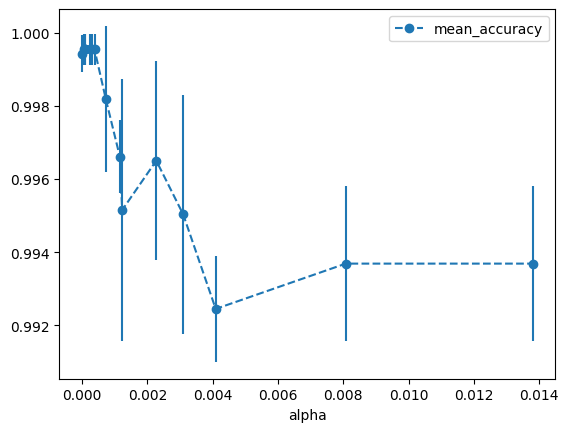

In [69]:
%%time

dt = tree.DecisionTreeClassifier(criterion='entropy')

path = dt.cost_complexity_pruning_path(X_train, y_train)

ccp_alphas = path.ccp_alphas

ccp_alphas = ccp_alphas[:-1] # exlude the maximum value

alpha_loop_values = []

for ccp_alpha in ccp_alphas:

    dt = tree.DecisionTreeClassifier(criterion='entropy', ccp_alpha=ccp_alpha)

    scores = cross_val_score(dt, X_train, y_train, scoring='recall', cv=kf)

    alpha_loop_values.append([ccp_alpha, np.mean(scores), np.std(scores)])


# Plot a graph of the means and standard deviations of the scores for each candidate
alpha_results = pd.DataFrame(alpha_loop_values, columns=['alpha', 'mean_accuracy', 'std'])

alpha_results.plot(x='alpha',
                    y='mean_accuracy',
                    yerr='std',
                    marker='o',
                    linestyle='--')

ideal_ccp_alpha = alpha_results.sort_values(by=['mean_accuracy'], ascending=False).iloc[0]
ideal_ccp_alpha = float(ideal_ccp_alpha['alpha'])
print(f"Optimal alpha value: {ideal_ccp_alpha}")

In [70]:
# build the optimum tree
decision_tree = tree.DecisionTreeClassifier(criterion='entropy', ccp_alpha=ideal_ccp_alpha)
decision_tree.fit(X_train, y_train)
model_dt = decision_tree
dt_test_pre = model_dt.predict(X_test)

dt_accuracy = accuracy_score(y_test, dt_test_pre)
dt_pre_f1 = f1_score(y_test, dt_test_pre)
dt_recall= recall_score(y_test, dt_test_pre)
dt_precision = precision_score(y_test, dt_test_pre)


print("==================Evaluation Score==================")
print(f"Accuracy: {dt_accuracy:.5f}")
print(f"test_F1: \n{dt_pre_f1}")
print(f"test_Recall: \n{dt_recall}")
print(f"test_Precision: \n{dt_precision}")
print("===================================================")

==================Evaluation Score==================
Accuracy: 0.99995
test_F1: 
0.999771167048055
test_Recall: 
1.0
test_Precision: 
0.9995424388011896


In [71]:
#Saving model
joblib.dump(model_dt, "/content/drive/MyDrive/adversarial trained models/ad_decisiontree.pkl")

['/content/drive/MyDrive/adversarial trained models/ad_decisiontree.pkl']

##Logistic Regression

In [72]:
##Baseline
from sklearn.linear_model import LogisticRegression
#the default hyperparameters
lg = LogisticRegression()
# Fit model
lg .fit(X_train, y_train)

#predict
lg_pred = lg.predict(X_test)

# print prediction results
print(classification_report(y_test, lg_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     32798
           1       0.94      0.96      0.95      4369

    accuracy                           0.99     37167
   macro avg       0.97      0.97      0.97     37167
weighted avg       0.99      0.99      0.99     37167



In [73]:
lg_pipeline = make_pipeline(SMOTE(sampling_strategy= 1 , random_state=12, n_jobs= -1), LogisticRegression())

lg_pipeline

Pipeline(steps=[('smote',
                 SMOTE(n_jobs=-1, random_state=12, sampling_strategy=1)),
                ('logisticregression', LogisticRegression())])

In [74]:
cross_val_score(lg_pipeline, X_train, y_train, scoring='recall', cv=kf, n_jobs=-1)

array([0.99492672, 0.98985344, 0.99210823, 0.99097575, 0.98928974])

In [75]:
#GridSearch
%%time

lg_params =  {'penalty':['l2', 'none'],
             'C':[1,10, 100, 1000],
             'max_iter':[500, 1000, 1500],
             'solver' : ['lbfgs', 'sag', 'saga']
             }


lg_new_params = {'logisticregression__' + key: lg_params[key] for key in lg_params}

lg_grid = GridSearchCV(lg_pipeline, param_grid= lg_new_params, cv=kf, scoring='recall', n_jobs=-1,
                        return_train_score=True, verbose=0)

#Fit
lg_grid.fit(X_train, y_train)

##the result of GridSearch

  #Best Score: Recall
lg_best = lg_grid.best_score_
  #Optimized hyperparameters
lg_opt_params = lg_grid.best_params_

print("=================GridSearch Result=================")
print()
print(f"GridSearch Best Score_Recall: \n{lg_best}")
print(f"Best Hyperparameters: \n{lg_opt_params}")
print()
print("===================================================")

/usr/local/lib/python3.10/dist-packages/imblearn/over_sampling/_smote/base.py:336: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


=================GridSearch Result=================

GridSearch Best Score_Recall: 
0.9915435147403968
Best Hyperparameters: 
{'logisticregression__C': 1, 'logisticregression__max_iter': 500, 'logisticregression__penalty': 'none', 'logisticregression__solver': 'lbfgs'}

CPU times: user 20.2 s, sys: 37.1 s, total: 57.2 s
Wall time: 18min 55s


In [76]:
##Evaluate Model

# Prediction using Estimator that was chosen by the GridSearch for testing dataset
model_lg = lg_grid.best_estimator_

lg_test_pre = model_lg.predict(X_test)

lg_pre_accuracy = accuracy_score(y_test, lg_test_pre)
lg_pre_f1 = f1_score(y_test, lg_test_pre)
lg_recall= recall_score(y_test, lg_test_pre)
lg_precision = precision_score(y_test, lg_test_pre)

print(classification_report(y_test, lg_test_pre))
print()
print("==================Evaluation Score==================")
print(f"test_Accuracy: \n{lg_pre_accuracy}")
print(f"test_F1: \n{lg_pre_f1}")
print(f"test_Recall: \n{lg_recall}")
print(f"test_Precision: \n{lg_precision}")
print("===================================================")

              precision    recall  f1-score   support

           0       1.00      0.99      0.99     32798
           1       0.92      0.99      0.95      4369

    accuracy                           0.99     37167
   macro avg       0.96      0.99      0.97     37167
weighted avg       0.99      0.99      0.99     37167


==================Evaluation Score==================
test_Accuracy: 
0.9882422579169694
test_F1: 
0.9518881426841354
test_Recall: 
0.9894712748912795
test_Precision: 
0.9170555791260077


In [77]:
#Saving model
joblib.dump(model_lg, "/content/drive/MyDrive/adversarial trained models/ad_logisticregression.pkl")

['/content/drive/MyDrive/adversarial trained models/ad_logisticregression.pkl']